In [2]:
import numpy as np
import pandas as pd
import os
import sys
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import seaborn as sns
import sklearn
from scipy import stats
%matplotlib inline
state = 32
print ('numpy version:', np.__version__, 'pandas version:', pd.__version__)

numpy version: 1.21.5 pandas version: 1.3.4


### READ DATA

In [3]:
df = pd.read_excel('vesselData.xlsx')
df

,eta,ata,atd,vesseldwt,vesseltype,discharge1,load1,discharge2,load2,discharge3,...,load4,stevedorenames,hasnohamis,earliesteta,latesteta,traveltype,previousportid,nextportid,isremarkable,vesselid
0,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,2017-09-22 00:00:00+00,109290.0,5.0,0.0,0.0,0.0,0.0,90173.0,...,0.0,Stevedore_104,NaN,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,ARRIVAL,981.0,731.0,f,2242.0
1,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,67170.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_109,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,19.0,15.0,f,5462.0
2,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,2017-10-01 00:00:00+00,67737.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,ARRIVAL,19.0,19.0,f,5251.0
3,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,43600.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,15.0,18.0,f,5268.0
4,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,9231.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_98,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,74.0,27.0,f,5504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,2017-11-03 00:00:00+00,2017-11-03 00:00:00+00,2017-11-04 00:00:00+00,9587.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_64,NaN,2017-11-02 00:00:00+00,2017-11-03 00:00:00+00,ARRIVAL,5.0,19.0,f,5681.0
8204,2017-11-04 00:00:00+00,2017-11-04 00:00:00+00,2017-11-06 00:00:00+00,9654.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,"Stevedore_110,Stevedore_57,Stevedore_99,Steved...",NaN,2017-11-04 00:00:00+00,2017-11-05 00:00:00+00,SHIFT,391.0,102.0,f,4843.0
8205,2017-11-08 00:00:00+00,2017-11-07 00:00:00+00,2017-11-11 00:00:00+00,4726.0,5.0,0.0,0.0,0.0,0.0,0.0,...,3051.0,"Stevedore_89,Stevedore_79,Stevedore_75,Stevedo...",NaN,2017-11-07 00:00:00+00,2017-11-10 00:00:00+00,SHIFT,1043.0,19.0,f,3115.0
8206,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,13320.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_46,NaN,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,ARRIVAL,54.0,71.0,f,4623.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8208 entries, 0 to 8207
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eta             8208 non-null   object 
 1   ata             8208 non-null   object 
 2   atd             8208 non-null   object 
 3   vesseldwt       8206 non-null   float64
 4   vesseltype      8208 non-null   float64
 5   discharge1      8208 non-null   float64
 6   load1           8208 non-null   float64
 7   discharge2      8208 non-null   float64
 8   load2           8208 non-null   float64
 9   discharge3      8208 non-null   float64
 10  load3           8208 non-null   float64
 11  discharge4      8208 non-null   float64
 12  load4           8208 non-null   float64
 13  stevedorenames  8206 non-null   object 
 14  hasnohamis      0 non-null      float64
 15  earliesteta     8208 non-null   object 
 16  latesteta       8208 non-null   object 
 17  traveltype      8208 non-null   o

### INVESTIGATE TARGET VARIABLES

In [5]:
targets_df = df[['load1', 'discharge1','load2', 'discharge2', 'load3', 'discharge3', 'load4', 'discharge4']]
targets_df

,load1,discharge1,load2,discharge2,load3,discharge3,load4,discharge4
0,0.0,0.0,0.0,0.0,0.0,90173.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8205,0.0,0.0,0.0,0.0,0.0,0.0,3051.0,3537.0
8206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
targets_df.describe()

,load1,discharge1,load2,discharge2,load3,discharge3,load4,discharge4
count,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000
mean,60.754386,1732.712841,19.387549,1168.698221,44.745492,4791.331871,1509.046784,1820.782407
std,1325.463945,16297.994648,665.333248,11331.135301,3071.717973,25366.035772,11936.519585,10034.936858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41761.000000,204304.000000,43639.000000,189933.000000,271251.000000,299647.000000,293449.000000,183837.000000


In [7]:
for i in range(1,5):
    print (f'load{i}',targets_df.loc[targets_df[f'load{i}'] > 0, f'load{i}'].count())
print('-----')
for i in range(1,5):
    print (f'discharge{i}',targets_df.loc[targets_df[f'discharge{i}'] > 0, f'discharge{i}'].count())

load1 40
load2 21
load3 8
load4 446
-----
discharge1 138
discharge2 112
discharge3 378
discharge4 558


### TARGETS INITIAL INSIGHTS
Cargo type 4 (petrol) is the least type with missing load and discharge data (446 load/ 558 discharge).

Based on a quick search https://bulkcarrierguide.com/cargo.html, I made an assumption: <br>
The handling of ore & coal might be similar (i.e., soild bulk cargo). Likewise oil & petrol (i.e., liquid bulk) might have similar handling routines in terms of safety, regulations, transportation. <br>

Therefore:<br>
Attempting to concatenate load1 + load2 --> load_solid <br>
Attempting to concatenate load3 + load4 --> load_liquid <br>
Attempting to concatenate discharge1 + discharge2 --> discharge_solid <br>
Attempting to concatenate discharge3 + discharge4 --> discharge_liquid <br>

This is to maximize the supervision signal to train our predictive model.

### SOLUTION OVERVIEW: <br>
Train one load model to predict load for both solid and liquid cargo.<br>
Train one discharge model to predict discharge for both solid and liquid cargo<br>

In [8]:
valid_load1 = targets_df.loc[targets_df['load1'] > 0, 'load1']
valid_load2 = targets_df.loc[targets_df['load2'] > 0, 'load2']
load_solid = pd.concat([valid_load1, valid_load2] )

valid_load3 = targets_df.loc[targets_df['load3'] > 0, 'load3']
valid_load4 = targets_df.loc[targets_df['load4'] > 0, 'load4']
load_liquid = pd.concat([valid_load3, valid_load4] )
load_liquid


valid_disc1 = targets_df.loc[targets_df['discharge1'] > 0, 'discharge1']
valid_disc2 = targets_df.loc[targets_df['discharge2'] > 0, 'discharge2']
disc_solid= pd.concat([valid_disc1, valid_disc2] )
disc_solid


valid_disc3 = targets_df.loc[targets_df['discharge3'] > 0, 'discharge3']
valid_disc4 = targets_df.loc[targets_df['discharge4'] > 0, 'discharge4']
disc_liquid= pd.concat([valid_disc3, valid_disc4] )
disc_liquid 


0        90173.0
8        14044.0
27      131231.0
36       99862.0
50      102817.0
          ...   
8131      5104.0
8188     15980.0
8191      4196.0
8194     28127.0
8205      3537.0
Length: 936, dtype: float64

### FEATURES SELECTION & ENGINEERING

1. Dropping common sense non-informative features
2. Engineering a new feature ```n_stevs``` outlining the number of stevedores per ship
3. Construct a ```process_time``` feature as the difference in days from the 2 dates ```atd ``` - ```ata```
4. Construct a binary variable ```bulk_type``` to define the cargo type {'solid': 0, 'liquid': 1}


In [9]:
# 1. Dropping common sense non-informative features
exclusion_set = ['ata', 'atd','eta', 'previousportid', 'nextportid','earliesteta', 'stevedorenames', 'vesselid', 'latesteta', 'hasnohamis']
feature_candidates = ['vesseldwt', 'vesseltype', 'traveltype', 'isremarkable']
feature_df = df[['vesseldwt', 'vesseltype', 'traveltype']]
feature_df

,vesseldwt,vesseltype,traveltype
0,109290.0,5.0,ARRIVAL
1,67170.0,3.0,ARRIVAL
2,67737.0,3.0,ARRIVAL
3,43600.0,3.0,ARRIVAL
4,9231.0,3.0,ARRIVAL
...,...,...,...
8203,9587.0,3.0,ARRIVAL
8204,9654.0,3.0,SHIFT
8205,4726.0,5.0,SHIFT
8206,13320.0,3.0,ARRIVAL


In [10]:
# 2. Engineering a new feature ```n_stevs``` outlining the number of stevedores per ship
df['stevedorenames'] = df['stevedorenames'].astype('str')
feature_df['n_stevs'] = df['stevedorenames'].str.split(',').apply(lambda x : len(x))
feature_df

D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,vesseldwt,vesseltype,traveltype,n_stevs
0,109290.0,5.0,ARRIVAL,1
1,67170.0,3.0,ARRIVAL,1
2,67737.0,3.0,ARRIVAL,1
3,43600.0,3.0,ARRIVAL,1
4,9231.0,3.0,ARRIVAL,1
...,...,...,...,...
8203,9587.0,3.0,ARRIVAL,1
8204,9654.0,3.0,SHIFT,5
8205,4726.0,5.0,SHIFT,4
8206,13320.0,3.0,ARRIVAL,1


In [11]:
# 3. construct process_time feature
ata = pd.to_datetime(df['ata']).dt.date
atd = pd.to_datetime(df['atd']).dt.date
feature_df['process_time'] = (atd - ata).dt.days
feature_df

D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,vesseldwt,vesseltype,traveltype,n_stevs,process_time
0,109290.0,5.0,ARRIVAL,1,3
1,67170.0,3.0,ARRIVAL,1,1
2,67737.0,3.0,ARRIVAL,1,1
3,43600.0,3.0,ARRIVAL,1,1
4,9231.0,3.0,ARRIVAL,1,0
...,...,...,...,...,...
8203,9587.0,3.0,ARRIVAL,1,1
8204,9654.0,3.0,SHIFT,5,2
8205,4726.0,5.0,SHIFT,4,4
8206,13320.0,3.0,ARRIVAL,1,0


In [12]:
# 4. construct the bulk_type feature
disc_liquid = disc_liquid[~ disc_liquid.index.duplicated()]
solid_bulk = pd.concat([load_solid, disc_solid], axis = 1)
solid_bulk.insert(0,'bulk', value ='solid')
liquid_bulk = pd.concat([load_liquid, disc_liquid], axis = 1)
liquid_bulk.insert(0,'bulk',value= 'liquid')

targs = pd.concat([solid_bulk, liquid_bulk], axis= 0)
targs.columns = ['bulk','load', 'discharge']
targs



,bulk,load,discharge
5,solid,NaN,72741.0
23,solid,4188.0,NaN
44,solid,39786.0,NaN
62,solid,NaN,50743.0
88,solid,7005.0,NaN
...,...,...,...
8188,liquid,NaN,15980.0
8191,liquid,4206.0,4196.0
8192,liquid,NaN,139431.0
8194,liquid,NaN,28127.0


In [13]:
feature_df = feature_df.join(targs, how= 'right')
feature_df

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk,load,discharge
0,109290.0,5.0,ARRIVAL,1,3,liquid,NaN,90173.0
5,74518.0,2.0,ARRIVAL,1,2,solid,NaN,72741.0
8,17069.0,5.0,ARRIVAL,1,1,liquid,NaN,14044.0
23,7133.0,3.0,ARRIVAL,1,1,solid,4188.0,NaN
27,158070.0,5.0,ARRIVAL,1,2,liquid,NaN,131231.0
...,...,...,...,...,...,...,...,...
8188,25432.0,5.0,ARRIVAL,1,2,liquid,NaN,15980.0
8191,4993.0,5.0,SHIFT,2,8,liquid,4206.0,4196.0
8192,158583.0,5.0,SHIFT,2,2,liquid,NaN,139431.0
8194,37296.0,5.0,ARRIVAL,1,4,liquid,NaN,28127.0


In [14]:
# feature_df[['vesseltype','traveltype','bulk']] = feature_df[['vesseltype','traveltype','bulk']].apply(lambda col: col.astype('category'), axis=1)

In [15]:
feature_df['vesseltype'] = feature_df['vesseltype'].astype('category')
feature_df[['vesseltype','traveltype','bulk']].describe()

,vesseltype,traveltype,bulk
count,1606.0,1606,1606
unique,3.0,2,2
top,5.0,ARRIVAL,liquid
freq,1262.0,1312,1296


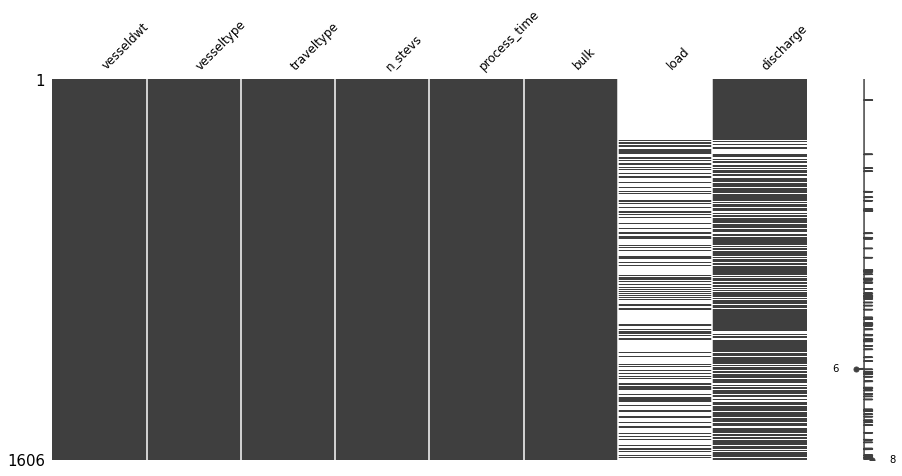

In [16]:
msno.matrix(feature_df.sort_values(by=['vesseltype'], ascending=True), figsize= (15,7), fontsize = 12)
plt.show()

D:\anaconda3\envs\omdena\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


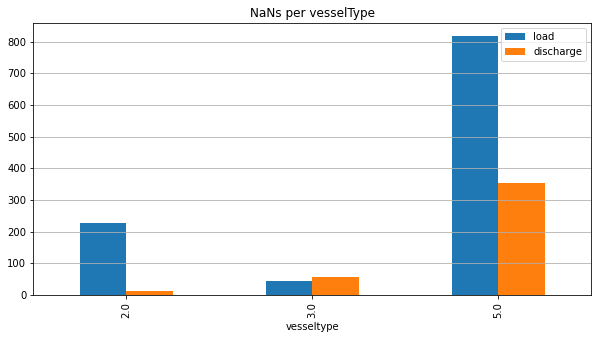

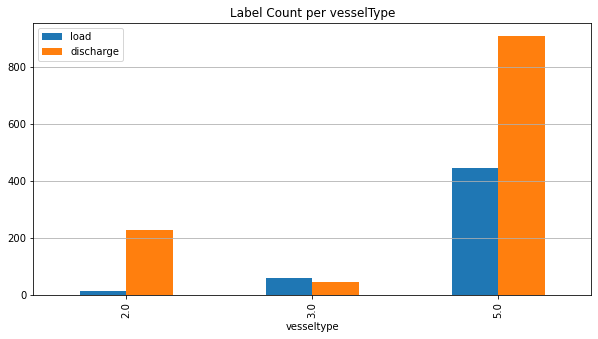

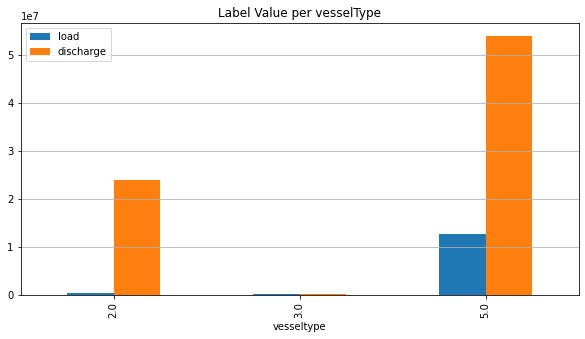

In [17]:
feature_df[['load','discharge']].isna().groupby(by=feature_df['vesseltype']).sum().plot.bar(figsize = (10,5), title = 'NaNs per vesselType')
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge']].groupby(by=feature_df['vesseltype'], dropna= True).count().plot.bar(figsize = (10,5), title = 'Label Count per vesselType')
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge']].groupby(by=feature_df['vesseltype'], dropna= True).sum().plot.bar(figsize = (10,5), title = 'Label Value per vesselType')
plt.grid(axis = 'y', linestyle='-')
plt.show()



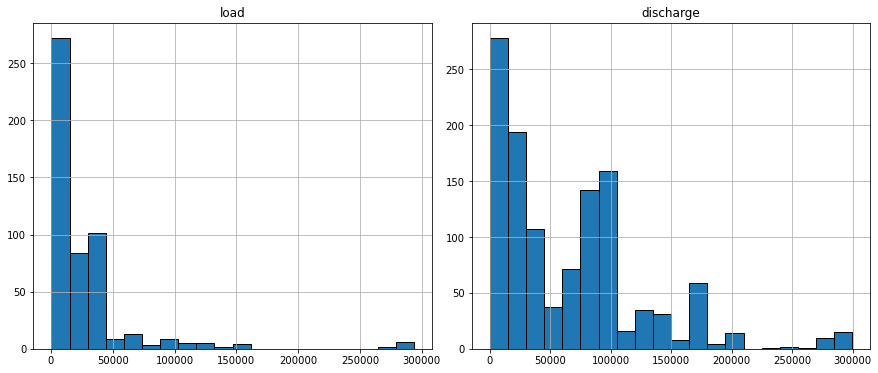

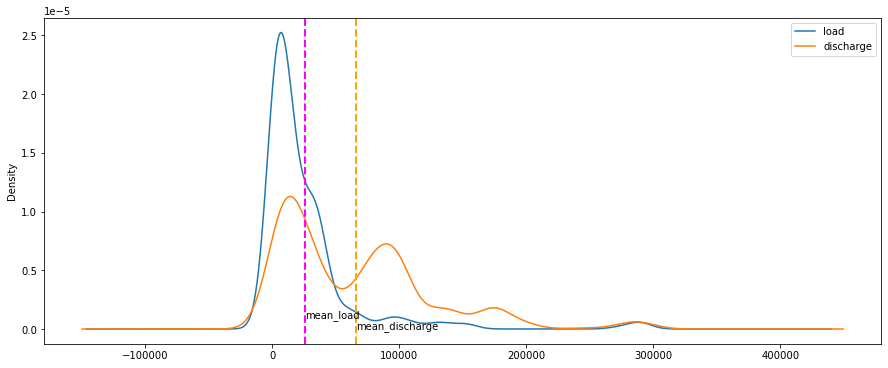

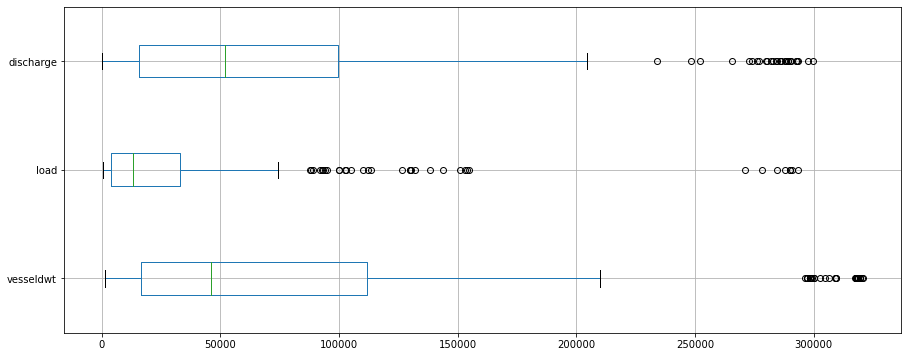

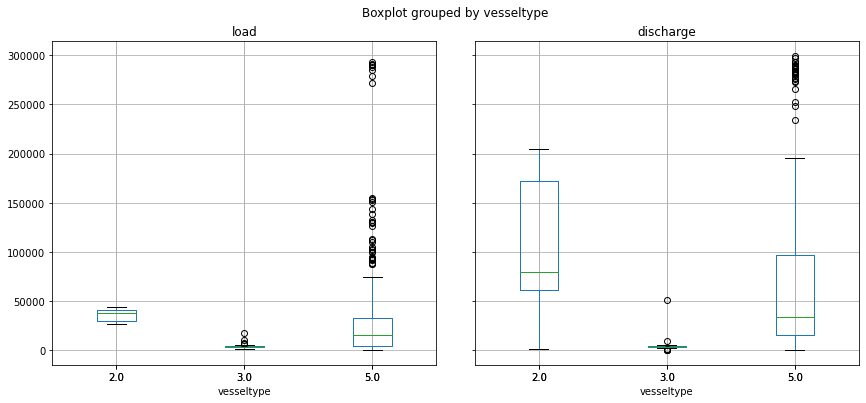

In [18]:
load_mean = feature_df['load'].mean()
discharge_mean = feature_df['discharge'].mean()
feature_df.hist(['load', 'discharge'], bins=20, figsize=(15,6), edgecolor='k')
plt.subplots_adjust(wspace= 0.1)
feature_df[['load','discharge']].plot.density(bw_method = 0.2, figsize = (15,6))
plt.axvline(x=load_mean, color = 'magenta', linestyle='dashed', linewidth = 2)
plt.axvline(x=discharge_mean, color = 'orange', linestyle='dashed', linewidth = 2)
plt.text(load_mean, y= 0.1e-5, s= 'mean_load')
plt.text(discharge_mean, y= 0, s= 'mean_discharge')
plt.subplots_adjust(wspace= 0.0001)
plt.show()
feature_df.boxplot(['vesseldwt','load','discharge'], vert = False, figsize=(15,6))
feature_df.boxplot(['load','discharge'], by='vesseltype', figsize=(14,6))
plt.subplots_adjust(wspace= 0.1)

plt.show()

In [19]:
feature_df.loc[feature_df['load'] >= 250000]

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk,load,discharge
865,302845.0,5.0,SHIFT,2,3,liquid,287721.0,288241.0
1329,297376.0,5.0,ARRIVAL,5,2,liquid,284559.0,280540.0
1369,318513.0,5.0,SHIFT,2,8,liquid,293449.0,284196.0
2718,298330.0,5.0,ARRIVAL,2,2,liquid,289998.0,289310.0
2791,156572.0,5.0,SHIFT,2,36,liquid,271251.0,265727.0
2818,317356.0,5.0,ARRIVAL,1,2,liquid,289971.0,251985.0
5426,318517.0,5.0,SHIFT,2,7,liquid,290977.0,NaN
6770,309164.0,5.0,ARRIVAL,1,3,liquid,278348.0,293409.0


### FEATURE ENCODING

In [20]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
curated_df = pd.get_dummies(feature_df, columns=['vesseltype','traveltype','bulk'])
curated_df

,vesseldwt,n_stevs,process_time,load,discharge,vesseltype_2.0,vesseltype_3.0,vesseltype_5.0,traveltype_ARRIVAL,traveltype_SHIFT,bulk_liquid,bulk_solid
0,109290.0,1,3,NaN,90173.0,0,0,1,1,0,1,0
5,74518.0,1,2,NaN,72741.0,1,0,0,1,0,0,1
8,17069.0,1,1,NaN,14044.0,0,0,1,1,0,1,0
23,7133.0,1,1,4188.0,NaN,0,1,0,1,0,0,1
27,158070.0,1,2,NaN,131231.0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8188,25432.0,1,2,NaN,15980.0,0,0,1,1,0,1,0
8191,4993.0,2,8,4206.0,4196.0,0,0,1,0,1,1,0
8192,158583.0,2,2,NaN,139431.0,0,0,1,0,1,1,0
8194,37296.0,1,4,NaN,28127.0,0,0,1,1,0,1,0


In [21]:
load_dataset = curated_df.dropna(subset=['load']).drop('discharge', axis= 1)
discharge_dataset = curated_df.dropna(subset=['discharge']).drop('load', axis= 1)
discharge_dataset

,vesseldwt,n_stevs,process_time,discharge,vesseltype_2.0,vesseltype_3.0,vesseltype_5.0,traveltype_ARRIVAL,traveltype_SHIFT,bulk_liquid,bulk_solid
0,109290.0,1,3,90173.0,0,0,1,1,0,1,0
5,74518.0,1,2,72741.0,1,0,0,1,0,0,1
8,17069.0,1,1,14044.0,0,0,1,1,0,1,0
27,158070.0,1,2,131231.0,0,0,1,1,0,1,0
36,111775.0,1,4,99862.0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8188,25432.0,1,2,15980.0,0,0,1,1,0,1,0
8191,4993.0,2,8,4196.0,0,0,1,0,1,1,0
8192,158583.0,2,2,139431.0,0,0,1,0,1,1,0
8194,37296.0,1,4,28127.0,0,0,1,1,0,1,0


### MODELING

In [ ]:
from sklearn.model_selection import train_test_split
X = discharge_dataset.drop('discharge', axis= 1)
y = discharge_dataset[['discharge']]
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size= 0.2)
print (xtrain.shape, xtest.shape)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size= 0.25)
print (xtrain.shape, xval.shape)

In [1]:
params = {'objective': 'reg:squarederror' , 'learning_rate': 0.3, 'gamma': 0, 'max_depth': 6, 'missing': 0, 'seed': 32 , 'subsample': 0.5, 'colsample_bytree': 0.5,
'reg_lambda': 0, 'n_estimators': 3000, 'eval_metric': ['mae','rmse']}
model = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
eval_sets = [ (xtrain, ytrain), (xval, yval)]
# model.get_xgb_params()

NameError: name 'xgb' is not defined

In [24]:
model.fit(xtrain, ytrain, eval_set= eval_sets, verbose= True, early_stopping_rounds= 10)

[0]	validation_0-mae:49954.62109	validation_0-rmse:73590.21094	validation_1-mae:51436.68359	validation_1-rmse:74319.30469
[1]	validation_0-mae:43057.38672	validation_0-rmse:63434.97656	validation_1-mae:45494.05859	validation_1-rmse:64733.86328
[2]	validation_0-mae:31443.20508	validation_0-rmse:45979.85156	validation_1-mae:33659.00000	validation_1-rmse:46939.25391
[3]	validation_0-mae:24373.50977	validation_0-rmse:35222.64062	validation_1-mae:26589.68555	validation_1-rmse:36721.05859
[4]	validation_0-mae:23385.48828	validation_0-rmse:32918.02734	validation_1-mae:25414.04297	validation_1-rmse:34303.25781
[5]	validation_0-mae:18816.12305	validation_0-rmse:25932.27539	validation_1-mae:20765.15820	validation_1-rmse:28156.00391
[6]	validation_0-mae:16014.45898	validation_0-rmse:22211.40820	validation_1-mae:18096.23047	validation_1-rmse:24983.41797
[7]	validation_0-mae:15706.39160	validation_0-rmse:21731.25391	validation_1-mae:17840.84375	validation_1-rmse:24588.33984
[8]	validation_0-mae:134

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             eval_metric=['mae', 'rmse'], gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=0, monotone_constraints='()',
             n_estimators=3000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=32, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, seed=32, subsample=0.5, tree_method='exact',
             validate_parameters=True, verbosity=1)

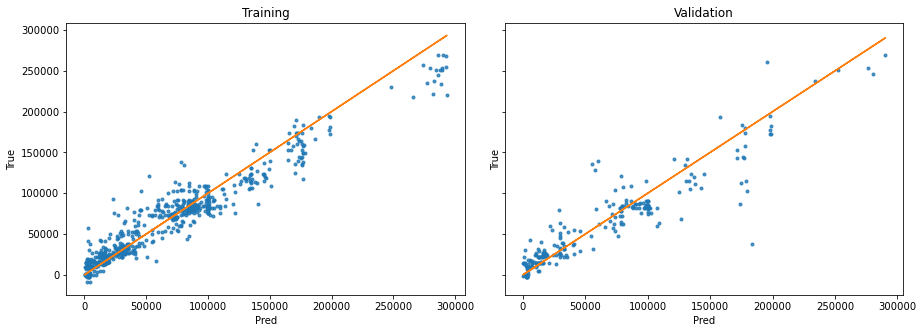

In [25]:
train_pred = model.predict(xtrain)
val_pred = model.predict(xval)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,5), sharey = True)
sns.regplot(x = ytrain, y = train_pred, fit_reg= False, marker = '.', ax = ax0)
sns.regplot(x = yval, y = val_pred, fit_reg= False, marker = '.', ax = ax1)
ax0.plot(ytrain, ytrain, '-')
ax0.set_xlabel('Pred')
ax0.set_ylabel('True')
ax0.set_title('Training')

ax1.plot(yval, yval, '-')
ax1.set_xlabel('Pred')
ax1.set_ylabel('True')
ax1.set_title('Validation')
plt.subplots_adjust(wspace=0.1)
plt.show()

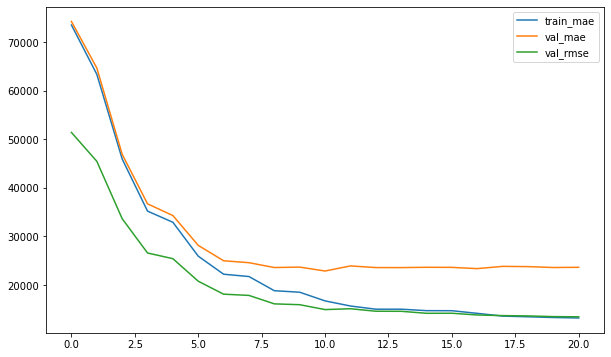

In [26]:
train_scores = pd.DataFrame(model.evals_result_['validation_0'])
val_scores = pd.DataFrame(model.evals_result_['validation_1'])
scores = pd.concat([train_scores, val_scores],axis= 1)
scores.columns = ['train_rmse', 'train_mae', 'val_rmse', 'val_mae']
scores[['train_mae', 'val_mae', 'val_rmse']].plot(figsize = (10,6))
# scores.plot(figsize = (10,6))
plt.show()

#### VANILLA-1 ERROR ESTIMATION

In [247]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV,ShuffleSplit, PredefinedSplit, LeaveOneOut, cross_val_score, cross_val_predict, KFold, GroupKFold, HalvingRandomSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error
from scipy.stats import t

In [28]:
# CV ALWAYS FOLLOW A HIGHER IS BETTER STRATEGY ACROSS SCORES & ERRORS --> ERRORS ARE NEGATED FOR STRATEGY CONSISTENCY
# median_absolute_error --> ROBUST AGAINST OUTLIERS
# K = 4 is the best trade off between the mean error and its variance. --> k = 4 gives around 250 instances for testing per iteration.
X_cv = pd.concat([xtrain, xval], axis= 0)
y_cv = pd.concat([ytrain, yval], axis= 0)
# cv_scheme = loo.split(X_cv, y_cv)
score_func = make_scorer(median_absolute_error, greater_is_better= False)

model_cv = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
cv_exp = cross_val_score(model, X_cv, y_cv, cv= 4, scoring= 'neg_median_absolute_error')

print(cv_exp)
print(f'mean:{cv_exp.mean():.2f} | std:{cv_exp.std():.2f}')

[-5465.74707031 -8378.421875   -7942.20703125 -6416.76953125]
mean:-7050.79 | std:1169.57


#### GK-FOLD

In [29]:
vessel_types = feature_df.loc[~feature_df.index.duplicated(), 'vesseltype']
df_merg = X_cv.merge(vessel_types, how='inner', left_index= True, right_index= True)
vessel_grps = df_merg['vesseltype'].astype('int').to_list()

In [30]:
grp_KFold = GroupKFold(3)
cv_scheme = grp_KFold.split(X_cv, y_cv, groups= vessel_grps)

model_cv = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
cv_exp = cross_val_score(model, X_cv, y_cv, cv= cv_scheme, scoring= 'neg_median_absolute_error')

print(cv_exp)
print(f'mean:{cv_exp.mean():.2f} | std:{cv_exp.std():.2f}')

[-38187.73876953 -34341.3203125  -16849.46875   ]
mean:-29792.84 | std:9286.08


#### VANILLA-1 PARAMETER SEARCH

#### SEARCH DISTs

0.03110558033627142 63.719341685269484


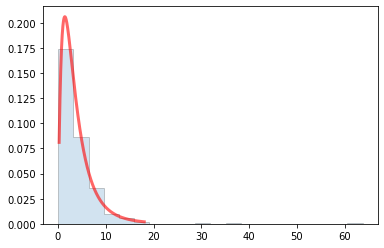

In [31]:
gamma_dist = stats.betaprime(a = 2,b =6, scale = 10)
sample = gamma_dist.rvs(size= 1000)
print( min(sample), max(sample) )


x = np.linspace(gamma_dist.ppf(0.01),
                gamma_dist.ppf(0.99), 1000)

plt.plot(x, gamma_dist.pdf(x),
       'r-', lw=3, alpha=0.6, label='expon pdf')
plt.hist(sample, density=True, histtype='stepfilled', alpha=.2, bins=20, linewidth=1, edgecolor='k')

plt.show()

0.0017645985755551379 20.026155130678408


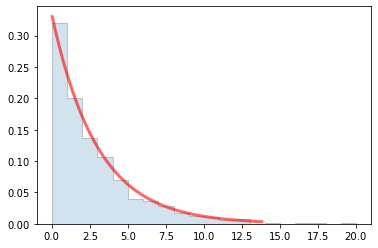

In [32]:
lambda_dist = stats.expon(scale = 3)
sample = lambda_dist.rvs(size= 1000)
print( min(sample), max(sample) )


x = np.linspace(lambda_dist.ppf(0.01),
                lambda_dist.ppf(0.99), 1000)

plt.plot(x, lambda_dist.pdf(x),
       'r-', lw=3, alpha=0.6, label='expon pdf')
plt.hist(sample, density=True, histtype='stepfilled', alpha=.2, bins=20, linewidth=1, edgecolor='k')

plt.show()

0.00010033900345970011 0.49227965931168277


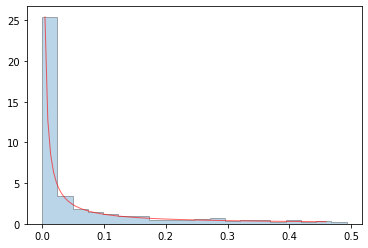

In [33]:
lr_dist = stats.loguniform(.0001, .5)
sample = lr_dist.rvs(size= 1000)
print (min(sample), max(sample))

x = np.linspace(lr_dist.ppf(.45), lr_dist.ppf(.99), 100)
plt.plot(x, lr_dist.pdf(x), 'r-', lw=1, alpha=0.6, label='lr_dist pdf')

plt.hist(sample, density=True, histtype='stepfilled', alpha=.3, bins=20, linewidth=1, edgecolor='k')

plt.show()

1 18


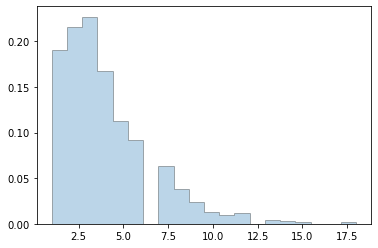

In [34]:
maxchild_dist = stats.nbinom(2, .4, loc = 1)
sample = maxchild_dist.rvs(size= 1000)
print (min(sample), max(sample))

plt.hist(sample, density=True, histtype='stepfilled', alpha=.3, bins=20, linewidth=1, edgecolor='k')

plt.show()

0.0447430213675835 0.9987799601705801


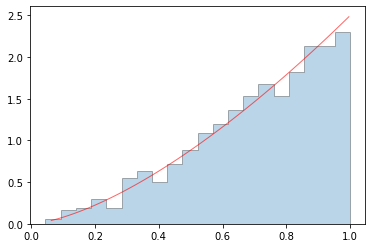

In [35]:
colrow_dist = stats.beta(2.5,1)
sample = colrow_dist.rvs(size= 1000)
print (min(sample), max(sample))

x = np.linspace(colrow_dist.ppf(.001), colrow_dist.ppf(.99), 100)
plt.plot(x, colrow_dist.pdf(x), 'r-', lw=1, alpha=0.6, label='lr_dist pdf')

plt.hist(sample, density=True, histtype='stepfilled', alpha=.3, bins=20, linewidth=1, edgecolor='k')

plt.show()

4 45


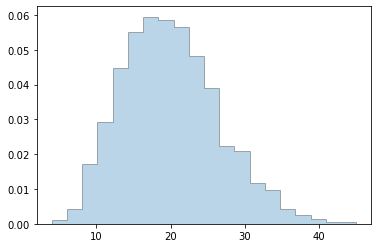

In [4]:
treedepth_dist = stats.nbinom(20, .5)
sample = treedepth_dist.rvs(size= 1000)
print (min(sample), max(sample))


plt.hist(sample, density=True, histtype='stepfilled', alpha=.3, bins=20, linewidth=1, edgecolor='k')

plt.show()

## SEARCH

In [37]:
# search_space = {'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
#                 'max_depth':[6, 12, 32, 48],
#                 'subsample': [0.3, 0.5, 0.7, 0.9],
#                 'colsample_bytree': [0.1, 0.5, 0.8, 1],
#                 'reg_lambda': [0, 0.1, 0.5, 1, 2],
#                 'gamma': [0, 0.25, 0.5, 0.75, 1]}

search_space = {'learning_rate':lr_dist,
                'max_depth':treedepth_dist,
                'subsample': colrow_dist,
                'colsample_bytree': colrow_dist,
                'reg_lambda': lambda_dist,
                'min_child_weight': maxchild_dist,
                'gamma': gamma_dist}

In [ ]:
# model_cv = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
# rand_cv = RandomizedSearchCV(model_cv, search_space, verbose= 1,  n_iter= 50, cv= 4, scoring= 'neg_median_absolute_error', random_state= state)
# randcv_results = rand_cv.fit(X_cv, y_cv)
# print(randcv_results.best_score_)
# print(randcv_results.best_params_)

In [ ]:
# pd.DataFrame(randcv_results.cv_results_).iloc[:,11:].sort_values(by= 'rank_test_score')

# # randcv_results.cv_results_['mean_test_score']

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
37,"{'colsample_bytree': 0.9372081530005308, 'gamm...",-4895.195312,-4807.005859,-4389.343750,-5557.685547,-4912.307617,418.743707,1
35,"{'colsample_bytree': 0.9763907858379971, 'gamm...",-5553.892578,-5455.937500,-4699.156250,-4425.535156,-5033.630371,482.355886,2
47,"{'colsample_bytree': 0.9703474836228518, 'gamm...",-5580.953125,-5823.074219,-4428.250000,-4532.215820,-5091.123291,617.953070,3
13,"{'colsample_bytree': 0.7567038711222278, 'gamm...",-5271.641602,-5892.117188,-5031.651733,-4344.313965,-5134.931122,554.022250,4
41,"{'colsample_bytree': 0.706846033881246, 'gamma...",-5331.453125,-5798.723633,-5281.242188,-4558.750977,-5242.542480,443.370913,5
16,"{'colsample_bytree': 0.8700554913989299, 'gamm...",-5741.449219,-5000.171875,-5083.003906,-5751.566406,-5394.047852,353.692609,6
40,"{'colsample_bytree': 0.6946328526162001, 'gamm...",-5655.445312,-5423.234375,-5282.429688,-5373.710938,-5433.705078,137.624405,7
19,"{'colsample_bytree': 0.9141498369454172, 'gamm...",-6109.914062,-5556.458984,-4848.464844,-5526.516602,-5510.338623,447.201415,8
25,"{'colsample_bytree': 0.8428701282132932, 'gamm...",-5955.351562,-5733.531250,-4735.343750,-6231.993164,-5664.054932,564.521696,9
1,"{'colsample_bytree': 0.7847928149344324, 'gamm...",-6115.031250,-5439.728271,-5202.734375,-5911.811523,-5667.326355,363.269620,10


### Succsessive Halfing

In [39]:
model_cv = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
hrand_cv = HalvingRandomSearchCV(model_cv, search_space, factor = 2, min_resources='smallest',  n_candidates= 'exhaust', resource= 'n_samples',cv= 4, verbose= 3,n_jobs= -1 , scoring= 'neg_median_absolute_error', random_state= state)
hrandcv_results = hrand_cv.fit(X_cv, y_cv)
print(hrandcv_results.best_score_)
print(hrandcv_results.best_params_)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 8
max_resources_: 947
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 118
n_resources: 8
Fitting 4 folds for each of 118 candidates, totalling 472 fits
----------
iter: 1
n_candidates: 59
n_resources: 16
Fitting 4 folds for each of 59 candidates, totalling 236 fits
----------
iter: 2
n_candidates: 30
n_resources: 32
Fitting 4 folds for each of 30 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 15
n_resources: 64
Fitting 4 folds for each of 15 candidates, totalling 60 fits
----------
iter: 4
n_candidates: 8
n_resources: 128
Fitting 4 folds for each of 8 candidates, totalling 32 fits
----------
iter: 5
n_candidates: 4
n_resources: 256
Fitting 4 folds for each of 4 candidates, totalling 16 fits
----------
iter: 6
n_candidates: 2
n_resources: 512
Fitting 4 folds for each of 2 candidates, totalling 8 fits
-5448.002105712891
{'colsample_bytree': 0.9763907858379971, 'gamm

In [77]:
hrandcv_results.n_candidates_

[118, 59, 30, 15, 8, 4, 2]

In [198]:
results_df = pd.DataFrame(hrandcv_results.cv_results_).sort_values('rank_test_score')
results_df = results_df.loc[:,~results_df.columns.str.contains(r"time|param|train")]
testscores = results_df.filter(regex= r'split\d*_test_score')
results_df

,iter,n_resources,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
234,6,512,-4458.556274,-6207.030273,-5996.335938,-5130.085938,-5448.002106,699.440400,1
235,6,512,-3843.554810,-5253.088379,-6440.880859,-6270.722656,-5452.061676,1033.785990,2
233,5,256,-3987.553955,-5277.962891,-6889.515625,-10086.810547,-6560.460754,2280.793181,3
230,5,256,-6819.859375,-5810.484863,-5985.089844,-9911.375000,-7131.702271,1649.557666,4
227,4,128,-3571.683594,-8477.496094,-6028.654297,-13175.462891,-7813.324219,3548.598926,5
...,...,...,...,...,...,...,...,...,...
90,0,8,-211764.500000,-131015.500000,-166564.500000,-89451.500000,-149699.000000,45042.773585,216
91,0,8,-211764.500000,-131015.500000,-166564.500000,-89451.500000,-149699.000000,45042.773585,216
96,0,8,-211764.500000,-131015.500000,-166564.500000,-89451.500000,-149699.000000,45042.773585,216
64,0,8,-211764.500000,-131015.500000,-166564.500000,-89451.500000,-149699.000000,45042.773585,216


In [165]:
top_five = testscores.T.iloc[:,:5]
top_five.corr().style.background_gradient(cmap='coolwarm')


,234,235,233,230,227
234,1.000000,0.595529,0.098987,-0.478155,0.203230
235,0.595529,1.000000,0.806452,0.279469,0.634839
233,0.098987,0.806452,1.000000,0.792175,0.876711
230,-0.478155,0.279469,0.792175,1.000000,0.742982
227,0.203230,0.634839,0.876711,0.742982,1.000000


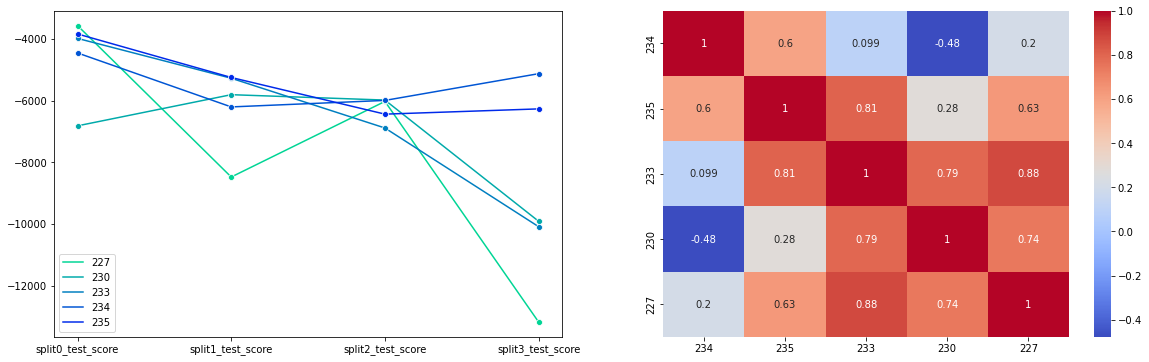

In [178]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (20,6))
sns.lineplot(data = top_five, legend= True, palette= 'winter_r', dashes= False, marker= 'o',ax = ax0)
sns.heatmap(top_five.corr(), ax= ax1, annot = True, cmap= 'coolwarm')
plt.show()

### Repeated CV + SuccessiveHalving: Pairwise model comparision


In [236]:
model_cv = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
rpt_cv = RepeatedKFold(n_splits=4, n_repeats= 1, random_state= state)
splts = list (rpt_cv.split(X_cv, y_cv) )
len(splts) # 4 x 10 = 40
print(len(splts[0]) , len(splts[0][0]), len(splts[0][1])) # train/test splits of Itr 0, len_trainSplit, len_testSplit (2, 710, 237)
successhv_cv = HalvingRandomSearchCV(model_cv, cv = rpt_cv, param_distributions= search_space, n_candidates= 10, min_resources= 'exhaust', factor= 2, resource= 'n_samples', verbose= 5,n_jobs= -1 , scoring= 'neg_median_absolute_error', random_state= state) 

In [237]:
successhv_results = successhv_cv.fit(X_cv, y_cv)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 118
max_resources_: 947
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 118
Fitting 4 folds for each of 10 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 5
n_resources: 236
Fitting 4 folds for each of 5 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 3
n_resources: 472
Fitting 4 folds for each of 3 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 944
Fitting 4 folds for each of 2 candidates, totalling 8 fits


In [264]:
succhv_results_df = pd.DataFrame(successhv_cv.cv_results_).sort_values('rank_test_score')
succhv_results_df = succhv_results_df.loc[:,~succhv_results_df.columns.str.contains(r"time|param|train")]
succhv_testscores = succhv_results_df.filter(regex= r'split\d*_test_score')
succhv_results_df[succhv_results_df.eval('n_resources > 900')]

,iter,n_resources,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
18,3,944,-5917.699951,-5664.361328,-6628.906250,-5810.550781,-6005.379578,371.054219,2
19,3,944,-5586.427734,-6521.471680,-6171.387695,-5855.679688,-6033.741699,349.507803,3


In [312]:
# Nadeau Bengio test
best_1 = succhv_testscores.iloc[2].values
best_2 = succhv_testscores.iloc[-1].values

diff = best_1 - best_2
dfs = len(diff) - 1
n = len(diff)
n_train = len(splts[0][0])
n_test = len(splts[0][1])

def corrected_std (diff, n_train, n_test):
    kr = len(diff)  # (4 x 1)
    corrected_var = np.var(diff, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std
    
def Nadeau_Bengio_test(diff, df, n_train, n_test):
    mean = np.mean(diff)
    std = corrected_std(diff, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

t_stat, p_value = Nadeau_Bengio_test(diff, dfs, n_train, n_test)
print( t_stat, p_value )

1.7899509409702672 0.0856986589232503


In [330]:
best_models

,iter,n_resources,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
18,3,944,-5917.699951,-5664.361328,-6628.906250,-5810.550781,-6005.379578,371.054219,2
19,3,944,-5586.427734,-6521.471680,-6171.387695,-5855.679688,-6033.741699,349.507803,3
15,2,472,-5741.265625,-6510.576172,-5799.343750,-8073.562500,-6531.187012,940.600514,4
16,2,472,-5999.417969,-5368.203125,-8384.941406,-6984.035156,-6684.149414,1138.331745,5
17,2,472,-5992.230469,-5644.528320,-8715.208008,-7908.625000,-7065.147949,1284.860282,6


In [343]:
n_models = best_models.index.to_list()
model_combs = combinations(n_models, 2) 
list(model_combs)

[(18, 19),
 (18, 15),
 (18, 16),
 (18, 17),
 (19, 15),
 (19, 16),
 (19, 17),
 (15, 16),
 (15, 17),
 (16, 17)]

In [376]:
# Pairwise testing
from itertools import combinations
from scipy.special import comb
# n_combinations 20C2 = 190
best_models = succhv_results_df[succhv_results_df.eval('n_resources > 400')]
n_models = best_models.index.to_list()
model_combs = combinations(n_models, 2) # indices of all possible  model pairs combinations
ttest_results = pd.DataFrame(columns=['model_1', 'model_2', 't_stat', 'p_val'])

for m1_indx, m2_indx in model_combs:
    m1_score = best_models.loc[m1_indx]
    m2_score = best_models.loc[m2_indx]
    diff = m1_score - m2_score
    dofs = len(diff) - 1
    t_stat, p_val = Nadeau_Bengio_test(diff, dofs, n_train, n_test)
    p_val *= comb(len(n_models),2)
    p_val = 1 if p_val > 1 else p_val
    row = {'model_1': m1_indx, 'model_2': m2_indx, 'p_val': p_val, 't_stat':t_stat}
    ttest_results = ttest_results.append(row, ignore_index= True) 

ttest_results[['model_1', 'model_2']] = ttest_results[['model_1', 'model_2']].astype('int')
ttest_results

,model_1,model_2,t_stat,p_val
0,18,19,0.074507,1.0
1,18,15,0.461686,1.0
2,18,16,0.668581,1.0
3,18,17,0.792710,1.0
4,19,15,0.485663,1.0
5,19,16,0.489236,1.0
6,19,17,0.656571,1.0
7,15,16,0.087595,1.0
8,15,17,0.361988,1.0
9,16,17,0.890934,1.0


## LDS --> KERNEL SMOOTHING

What you should have done is first split the data into train and test and then perform all the usampling on the train and create a model and then test it on test data. You don't touch or modify the test data. 

This way you can actually prevent the data leakage. Now because you have upsampled first and then split, obviously your model would be better for every class. But I dont think it is a true generalized representation. You can use stratified splitting before splitting the data to represent all the class labels.

In [ ]:
# 1. Get the empirical distribution of the label space
# 2. Segment the label space into bins --> assign each label to a bin index

In [522]:
#print(ytrain.max() , ytrain.min() , ytrain.max() - ytrain.min())
# 10^ceiling(log10(x))
round_factor =  str(ytrain.discharge.astype('int').max()).__len__() - 1 
maxbin = np.round(ytrain.discharge.max(), -round_factor)
maxbin

300000.0

In [786]:
bins = np.arange(0, maxbin, 1000, dtype = 'int')
# bin_labels= np.arange(0, len(bins) - 1)
bin_labels= bins[1:]
bins.shape, bin_labels.shape

((300,), (299,))

In [938]:
data_dist, bin_edges = pd.cut(ytrain['discharge'], bins= bins, retbins= True, labels= bin_labels)
ytrain_bins = pd.concat([ytrain, data_dist], axis= 1)
ytrain_bins.columns = ['discharge', 'bin']
emp_hist =  data_dist.value_counts().sort_index().to_dict()
smooth_emp_hist = {bin: np.clip(freq, 5, 1000) for (bin,freq) in emp_hist.items()}
len(emp_hist), len(smooth_emp_hist)

(299, 299)

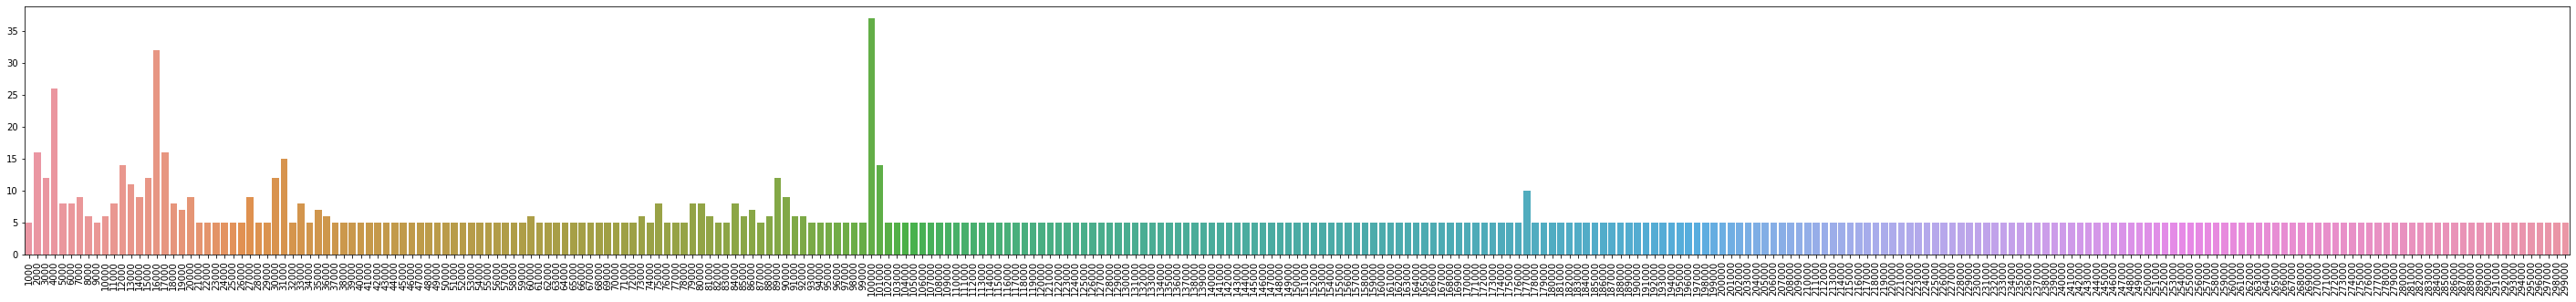

In [937]:
height = list(smooth_emp_hist.values())
data = list(smooth_emp_hist.keys()) 
plt.figure(figsize= (50,5))
sns.barplot(x= data, y= height)
plt.xticks(rotation=90)
plt.show()

In [944]:
# sqr_inv
sqrtinv_weights = {bin:np.sqrt(freq) for bin, freq in emp_hist.items()}
sqrtinv_weights

In [840]:
from scipy.ndimage import gaussian_filter1d, convolve1d
from scipy.signal.windows import gaussian, general_gaussian

half_ks = (5 - 1) // 2 # half of the kernel size
base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks ## Initialzie a basic symetric 1D kernel
base_kernel
base_kernel = [0.0, 0.0, 1, 0.0, 0.0]
k_w_filter = gaussian_filter1d(base_kernel, sigma=2) / max(gaussian_filter1d(base_kernel, sigma=2))
k_w = gaussian(5, 3, sym=True)

In [941]:
emp_freqs = np.asarray(list(emp_hist.values()))
emp_freqs.shape , len(emp_hist)
emp_freqs

array([ 5, 16, 12, 26,  8,  8,  9,  6,  4,  6,  8, 14, 11,  9, 12, 32, 16,
        8,  7,  9,  3,  3,  2,  2,  4,  3,  9,  5,  3, 12, 15,  4,  8,  5,
        7,  6,  2,  1,  3,  5,  3,  5,  3,  3,  5,  2,  2,  0,  2,  1,  2,
        1,  1,  0,  4,  2,  1,  1,  1,  6,  2,  1,  3,  3,  0,  4,  1,  4,
        2,  1,  5,  3,  6,  3,  8,  5,  5,  1,  8,  8,  6,  0,  3,  8,  6,
        7,  5,  6, 12,  9,  6,  6,  3,  2,  1,  0,  4,  2,  5, 37, 14,  2,
        0,  3,  2,  2,  1,  0,  0,  3,  0,  1,  1,  2,  2,  0,  0,  0,  0,
        0,  1,  3,  0,  0,  0,  2,  1,  0,  0,  1,  3,  0,  0,  3,  5,  5,
        1,  1,  0,  2,  2,  0,  0,  0,  1,  4,  1,  1,  0,  2,  2,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  0,  1,  0,  2,
        4,  2,  2,  4,  1,  3, 10,  0,  2,  0,  0,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  4,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [951]:
eff_freqs = convolve1d(emp_freqs, weights= k_w, mode='constant')
eff_freqs
effective_dist = {emp_key: eff_value for emp_key, eff_value in zip(emp_hist, eff_freqs)}
ytrain_bins['inv_weight'] = ytrain_bins.apply(lambda x: 1/effective_dist[x.loc['bin']], axis = 1)
scale = len(ytrain_bins['inv_weight']) / ytrain_bins['inv_weight'].sum()
ytrain_bins['inv_weight']  = ytrain_bins.apply(lambda x:  x.loc['inv_weight'] * scale , axis = 1)
ytrain_bins

,discharge,bin,inv_weight
581,45849.0,46000,1.224770
8192,139431.0,140000,3.368117
6956,176509.0,177000,0.898164
5960,2704.0,3000,0.217298
1542,92794.0,93000,0.842029
...,...,...,...
4420,93749.0,94000,1.347247
5057,90843.0,91000,0.421015
5713,112132.0,113000,2.694493
7516,9012.0,10000,0.408257


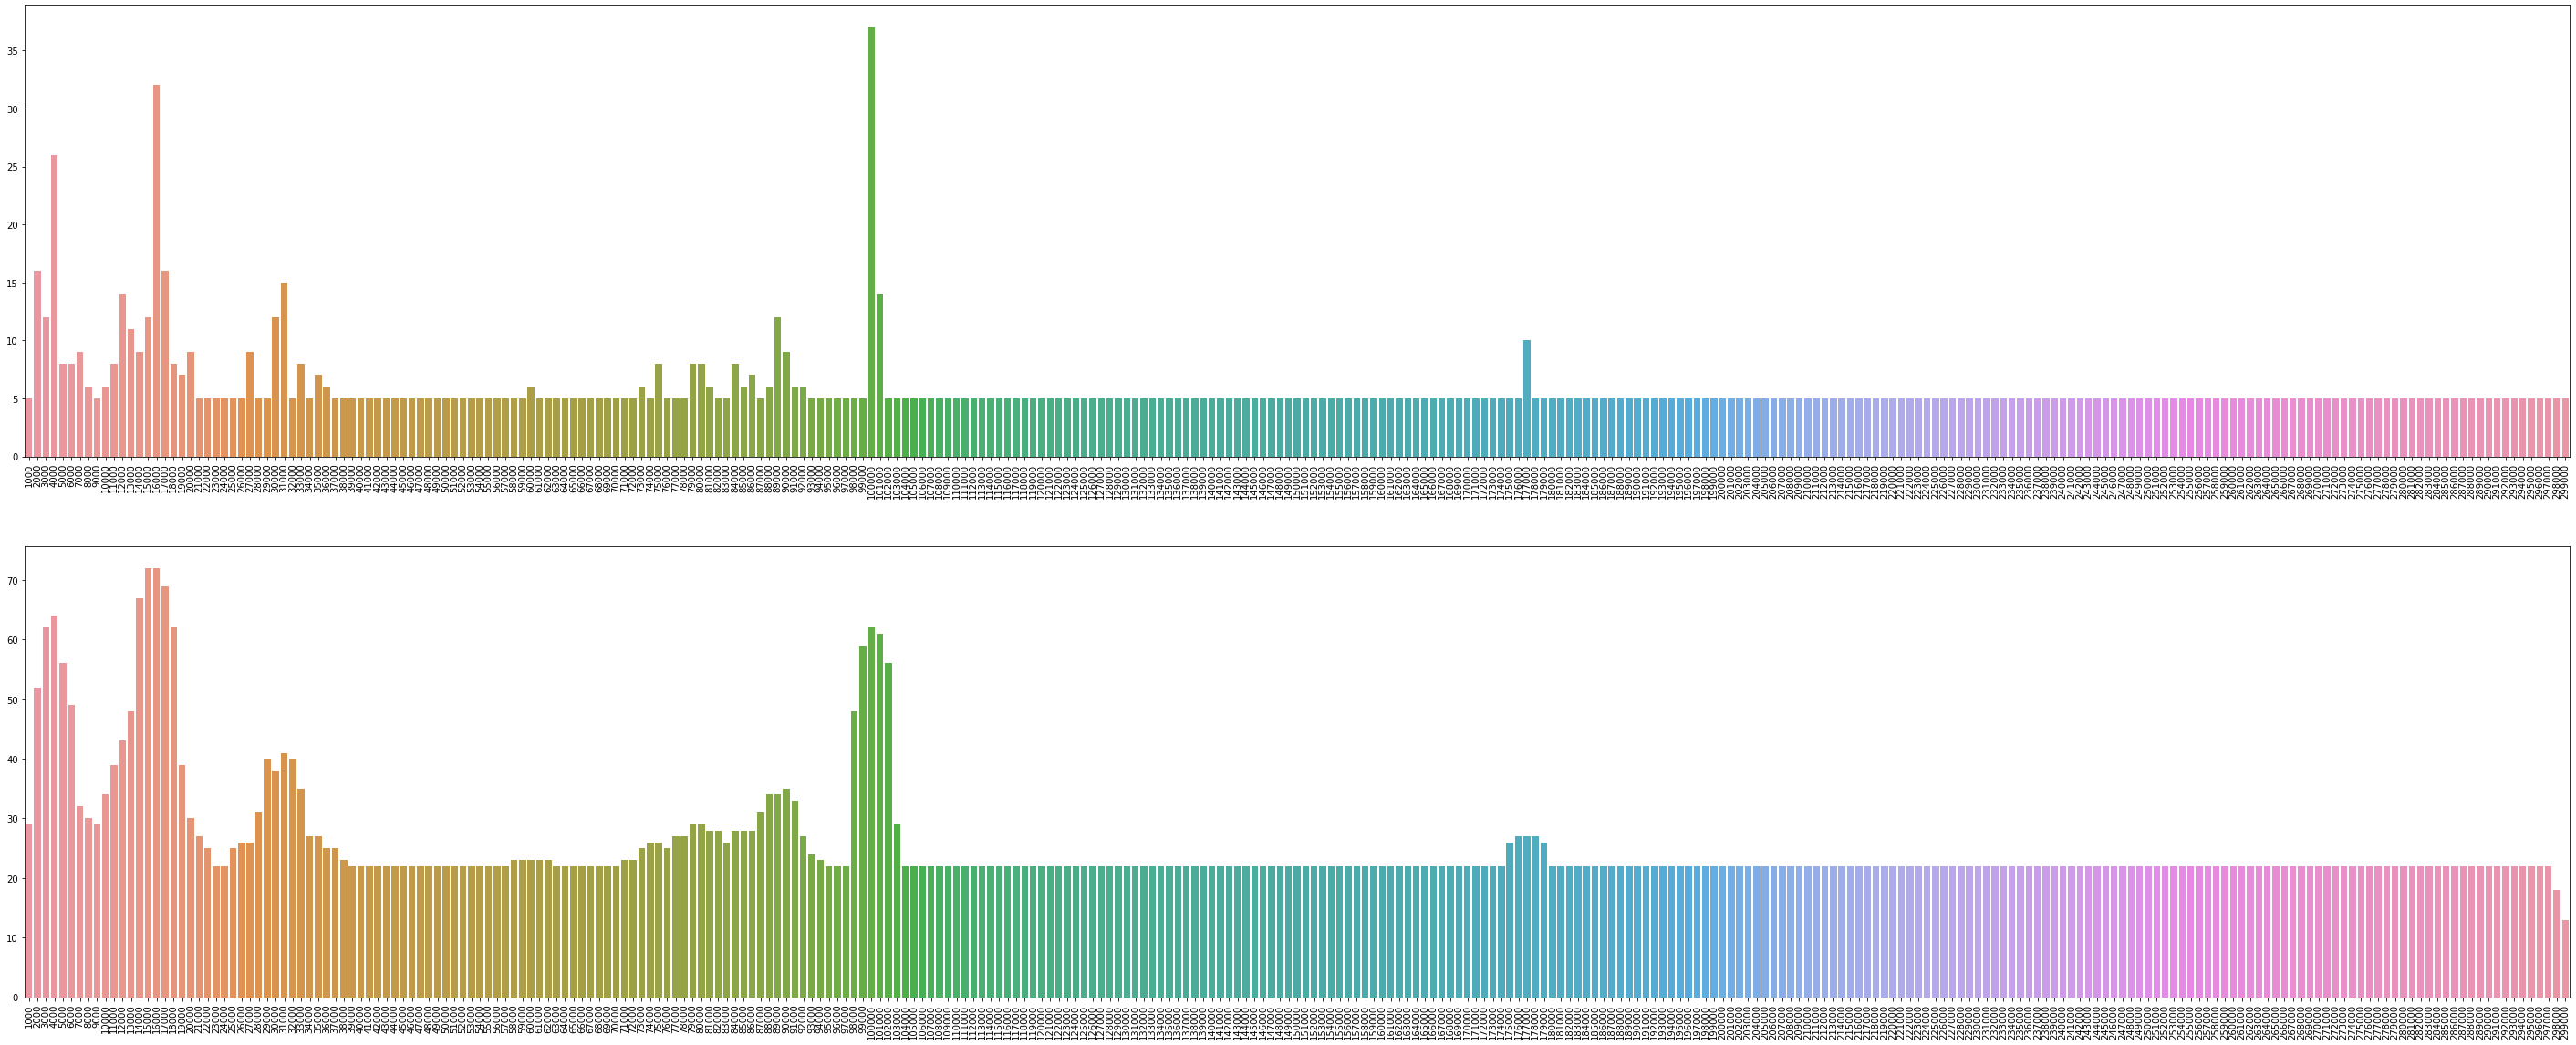

In [884]:
plt.figure(figsize= (50,20))

height = list(empirical_hist.values())
data = list(empirical_hist.keys()) 
plt.subplot(211)
sns.barplot(x= data, y= height)
plt.xticks(rotation=90)

height = list(effective_dist.values())
data = list(effective_dist.keys()) 
plt.subplot(212)
sns.barplot(x= data, y= height)
plt.xticks(rotation=90)
plt.show()